In [6]:
import csv
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
L = [1.5,1,1,1,1,1,1,1,1,1,1]

In [2]:
def S(bank_list,eta_list,lambda_list,method = "exposure"):
    H = np.diag(eta_list)
    if method == "exposure":
        M = np.transpose(np.array([i/sum(i) for i in bank_list]))
    else:
        alpha_i = eta_list**-1/(sum([i**-1 for i in eta_list]))
        M = np.repeat(a.reshape(len(eta_list),1),repeats = len(lambda_list),axis = 1)
    d = np.diag(np.sum(bank_list,axis = 1)*lambda_list)
    S = H.dot(M).dot(d).dot(np.transpose(M))
    #print (S)
    return S

def spectral_radius(S):
    eigs = np.linalg.eig(S)
    return max(eigs[0])

def price_contagion(X,delta_Z, method = "inverse"):
    I = np.identity(len(X))
    if method == "inverse":
        transfer = np.linalg.inv(I - X)
    else:
        transfer = I
        for i in range(1,method+1):
            transfer += np.linalg.matrix_power(S,i)
    #print (transfer)
    return transfer.dot(delta_Z)

def extra_loss(e,K,l_hat):
    fraction_ratio = np.empty([len(e),K])
    for i in range(len(e)):
        fraction_ratio[i,:]=np.random.dirichlet(np.ones(K),size=1)
    A = np.empty([len(e),K])
    for i in range(len(e)):
        for j in range(K):
            A[i,j]=fraction_ratio[i,j]*e[i]
    eta_list = []
    for i in range(K):
        eta_list.append(K/2000)
    lvg_ratio_lambda = np.empty(len(e))
    for i in range(len(e)):
        lvg_ratio_lambda[i]=e[i]*10
    liquid_ratio = []
    for j in range(len(e)):
        liquid_ratio.append(l_hat[j]/e[j])
    liquid_amnt_asst = []
    for i in range(K):
        ass = np.inner(np.array(liquid_ratio), A[:,i])
        liquid_amnt_asst.append(ass)
    delta_Z = []
    for i in range(K):
        delta_Z.append(-liquid_amnt_asst[i]/sum(A[:,i]))
    X=S(A,eta_list,lvg_ratio_lambda)
    p_dec_ratio = price_contagion(X,delta_Z)
    extra_loss = []
    for i in range(len(e)):
        ex_ls_firm =0
        for j in range(K):
            ex_ls_firm+=p_dec_ratio[j]*fraction_ratio[i,j]*(e[i]-l_hat[i])
        extra_loss.append(-ex_ls_firm)
    return extra_loss

# Complete

In [3]:
def complete(alpha,c,cap):
    bank_inf = np.empty([11,3])
    bank_inf[0,:]=[1.5,c,0.4]
    for i in range(1,6):
        bank_inf[i,:]=[1,0,cap]
    for i in range(6,11):
        bank_inf[i,:]=[1,0,1.2]
    beta =0.9
    p = [1.5,1,1,1,1,1,1,1,1,1,1]
    threshold = 0.001
    Finish = False
    while not Finish:
        p_temp = []
        for i in range(11):
            get_return = sum(p)*0.1-0.1*p[i]
            val_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return
            if val_paid >= bank_inf[i,0]:
                p_temp.append(bank_inf[i,0])
            else:
                new_paid = max(bank_inf[i,1]+alpha*bank_inf[i,2]+get_return*beta,0)
                p_temp.append(new_paid)
        diff = np.max(abs(np.array(p)-np.array(p_temp)))
        if diff <= threshold:
            Finish = True
            #print(np.around(p_temp,decimals=2))
        else:
            p = p_temp.copy()
    p = p_temp.copy()
    l = []
    for i in range(11):
        get_return = sum(p)*0.1-0.1*p[i]
        l_ = min((bank_inf[i,0]-bank_inf[i,1]-get_return)/alpha,bank_inf[i,2])
        l.append(l_)
    V0 = []
    for i in range(11):
        get_return = sum(bank_inf[:,0])*0.1-0.1*bank_inf[i,0]
        V0_i = bank_inf[i,1]+bank_inf[i,2]+get_return-bank_inf[i,0]
        V0.append(V0_i)
    zeta = []
    for i in range(11):
        zeta_i = 0.1*(sum(bank_inf[:,0])-bank_inf[i,0]) - 0.1*(sum(p)-p[i])
        zeta.append(zeta_i)
    xi = []
    for i in range(11):
        xi_i = min(zeta[i],V0[i]-(1-alpha)*bank_inf[i,2])
        xi.append(xi_i)
    l_hat = []
    for i in range(11):
        l_hat_i = max((xi[i]+bank_inf[i,2]-V0[i])/alpha,0)
        l_hat_i = min(l_hat_i,bank_inf[i,2])
        l_hat.append(l_hat_i)
    VN=[]
    for i in range(11):
        if i== 0:
            VN.append(0)
        else:
            VN_i = V0[i]-xi[i]-(1-alpha)*l_hat[i]
            VN.append(VN_i)
    s = bank_inf[0,1]+alpha*l[0]+beta*(sum(p)*0.1-0.1*p[i])
    wn = sum(V0)-sum(VN)-min(s,0)
    l_star = []
    for i in range(11):
        A_i = 0.1*(sum(bank_inf[:,0])-bank_inf[i,0])
        li_star = min(max((bank_inf[i,0]-bank_inf[i,1]-A_i)/alpha,0),bank_inf[i,2])
        l_star.append(li_star)
    eta = []
    for i in range(11):
        eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
        eta.append(eta_i)
    nu = []
    if alpha >= 0.5:
        for i in range(11):
            nu_i = xi[i]-(1-alpha)*(l_hat[i]-l_star[i])
            nu.append(nu_i)
    else:
        nu = eta.copy()
    b = []
    lambda_sub = []
    for i in range(1,11):
        if alpha >= 0.5:
            b.append(xi[i])
            lambda_sub.append(0)
        else:
            eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
            b.append(eta_i)
            lambda_sub.append(alpha*l_star[i])
    if alpha <0.5:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)
    else:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)-alpha*abs(bank_inf[0,2])
    wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))
    if alpha < 0.5:
        b0 = B + alpha*bank_inf[0,2]- sum(abs(np.array(b)))
    else:
        b0 = B - sum(abs(np.array(b)))

    if wn>wp:
        return (p,wn,wp,'Public bailin')
    else:
        nu_SC = nu[1:]
        sequence = [i[0] for i in sorted(enumerate(nu_SC), key=lambda x:x[1],reverse=True)]
        w_star = 0
        for i in range(len(sequence)):
            accept = sequence[:i+1]
            b_acc = 0
            lambda_acc = 0
            l_hat_acc = 0
            l_star_acc =0
            for i in accept:
                b_acc += abs(b[i])
                lambda_acc += abs(lambda_sub[i])
                l_hat_acc_i = min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2]) # check the i+1
                l_hat_acc+= l_hat_acc_i
                l_star_acc+=l_star[i+1]
            w_m = b0+sum(abs(np.array(b)))-b_acc+lambda_acc+(1-alpha)*((sum(abs(np.array(l_star))))-l_star_acc+l_hat_acc)
            if w_m < wn:
                if len(accept)<len(sequence):
                    w_star = min(w_m,wn-nu_SC[sequence[len(accept)]])
                    return (p,wn,w_star,'Bailin')
        if w_star == 0:
            return (p,wn,wn,'Default')
    

# R1

In [4]:
def r1(alpha,c,cap):
    bank_inf = np.empty([11,3])
    bank_inf[0,:]=[1.5,c,0.4]
    for i in range(1,6):
        bank_inf[i,:]=[1,0,cap]
    for i in range(6,11):
        bank_inf[i,:]=[1,0,1.2]
    beta =0.9
    p = [1.5,1,1,1,1,1,1,1,1,1,1]
    threshold = 0.0001
    Finish = False
    while not Finish:
        p_temp = []
        for i in range(11):
            if i==0:
                get_return = p[-1]
            else:
                get_return = p[i-1]
            val_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return
            if val_paid >= bank_inf[i,0]:
                p_temp.append(bank_inf[i,0])
            else:
                new_paid = max(bank_inf[i,1]+alpha*bank_inf[i,2]+get_return*beta,0)
                p_temp.append(new_paid)
        diff = np.max(abs(np.array(p)-np.array(p_temp)))
        if diff <= threshold:
            Finish = True    
        else:
            p = p_temp.copy()
    p = p_temp.copy()
    l = []
    for i in range(11):
        if i==0:
            get_return = p[-1]
        else:
            get_return = p[i-1]
        l_ = min((bank_inf[i,0]-bank_inf[i,1]-get_return)/alpha,bank_inf[i,2])
        l.append(l_)
    V0 = []
    for i in range(11):
        if i==0:
            get_return = bank_inf[-1,0]
        else:
            get_return=bank_inf[i-1,0]
        V0_i = bank_inf[i,1]+bank_inf[i,2]+get_return-bank_inf[i,0]
        V0.append(V0_i)
    zeta = []
    for i in range(11):
        if i == 0:
            zeta_i = bank_inf[-1,0]-p[-1]
            zeta.append(zeta_i)
        else:
            zeta_i = bank_inf[i-1,0]-p[i-1]
            zeta.append(zeta_i)
    xi = []
    for i in range(11):
        xi_i = min(zeta[i],V0[i]-(1-alpha)*bank_inf[i,2])
        xi.append(xi_i)
    l_hat = []
    for i in range(11):
        l_hat_i = max((xi[i]+bank_inf[i,2]-V0[i])/alpha,0)
        l_hat_i = min(l_hat_i,bank_inf[i,2])
        l_hat.append(l_hat_i)
    VN=[]
    for i in range(11):
        if i== 0:
            VN.append(0)
        else:
            VN_i = V0[i]-xi[i]-(1-alpha)*l_hat[i]
            VN.append(VN_i)
    s = bank_inf[0,1]+alpha*l[0]+beta*p[-1]
    wn = sum(V0)-sum(VN)-min(s,0)
    l_star = []
    for i in range(11):
        if i ==0:
            A_i = bank_inf[0,0]
        else:
            A_i = bank_inf[i-1,0]
        li_star = min(max((bank_inf[i,0]-bank_inf[i,1]-A_i)/alpha,0),bank_inf[i,2])
        l_star.append(li_star)
    eta = []
    for i in range(11):
        eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
        eta.append(eta_i)
    nu = []
    if alpha >= 0.5:
        for i in range(11):
            nu_i = xi[i]-(1-alpha)*(l_hat[i]-l_star[i])
            nu.append(nu_i)
    else:
        nu = eta.copy()
    b = []
    lambda_sub = []
    for i in range(1,11):
        if alpha >= 0.5:
            b.append(xi[i])
            lambda_sub.append(0)
        else:
            eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
            b.append(eta_i)
        lambda_sub.append(alpha*l_star[i])
    if alpha <0.5:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)
    else:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)-alpha*abs(bank_inf[0,2])
    wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))
    
    if alpha < 0.5:
        b0 = B + alpha*bank_inf[0,2]- sum(abs(np.array(b)))
    else:
        b0 = B - sum(abs(np.array(b)))
    if alpha >=0.8 and c>=-0.3:
        print(alpha,c,"wp:",wp,"wn:",wn)
    
    if wn>wp:
        return (p,wn,wp,'Public bailin')
    else:
        nu_SC = nu[1:]
        sequence = [i[0] for i in sorted(enumerate(nu_SC), key=lambda x:x[1],reverse=True)]
        w_star = 0
        for i in range(len(sequence)):
            accept = sequence[:i+1]
            b_acc = 0
            lambda_acc = 0
            l_hat_acc = 0
            l_star_acc =0
            for i in accept:
                b_acc += abs(b[i])
                lambda_acc += abs(lambda_sub[i])
                l_hat_acc_i = min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2]) # check the i+1
                l_hat_acc+= l_hat_acc_i
                l_star_acc+=l_star[i+1]
            w_m = b0+sum(abs(np.array(b)))-b_acc+lambda_acc+(1-alpha)*((sum(abs(np.array(l_star))))-l_star_acc+l_hat_acc)
            if w_m < wn:
                if len(accept)<len(sequence):
                    w_star = min(w_m,wn-nu_SC[sequence[len(accept)]])
                    if alpha >=0.8 and c>=-0.3:
                        print("w_r:",w_star)
                        print('____')
                    return (p,wn,w_star,'Bailin')
        if w_star ==0:
            return (p,wn,wn,'Default')
    
    

# R2

In [5]:
def r2(alpha,c,cap):
    bank_inf = np.empty([11,3])
    bank_inf[0,:]=[1.5,c,0.4]
    for i in range(1,6):
        bank_inf[i,:]=[1,0,cap]
    for i in range(6,11):
        bank_inf[i,:]=[1,0,1.2]
    beta =0.9
    p = [1.5,1,1,1,1,1,1,1,1,1,1]
    threshold = 0.0001
    Finish = False
    while not Finish:
        p_temp = []
        for i in range(11):
            if i==10:
                get_return = p[0]
            else:
                get_return = p[i+1]
            val_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return
            if val_paid >= bank_inf[i,0]:
                p_temp.append(bank_inf[i,0])
            else:
                new_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return*beta
                p_temp.append(new_paid)
        diff = np.max(abs(np.array(p)-np.array(p_temp)))
        if diff <= threshold:
            Finish = True
        else:
            p = p_temp.copy()
    p =p_temp.copy()
    l = []
    for i in range(11):
        if i==10:
            get_return = p[0]
        else:
            get_return = p[i+1]
        l_ = min((bank_inf[i,0]-bank_inf[i,1]-get_return)/alpha,bank_inf[i,2])
        l.append(l_)
    V0 = []
    for i in range(11):
        if i==10:
            get_return = bank_inf[0,0]
        else:
            get_return=bank_inf[i+1,0]
        V0_i = bank_inf[i,1]+bank_inf[i,2]+get_return-bank_inf[i,0]
        V0.append(V0_i)
    zeta = []
    for i in range(11):
        if i == 10:
            zeta_i = bank_inf[0,0]-p[0]
            zeta.append(zeta_i)
        else:
            zeta_i = bank_inf[i+1,0]-p[i+1]
            zeta.append(zeta_i)
    xi = []
    for i in range(11):
        xi_i = min(zeta[i],V0[i]-(1-alpha)*bank_inf[i,2])
        xi.append(xi_i)
    l_hat = []
    for i in range(11):
        l_hat_i = max((xi[i]+bank_inf[i,2]-V0[i])/alpha,0)
        l_hat_i = min(l_hat_i,bank_inf[i,2])
        l_hat.append(l_hat_i)
    VN=[]
    for i in range(11):
        if i== 0:
            VN.append(0)
        else:
            VN_i = V0[i]-xi[i]-(1-alpha)*l_hat[i]
            VN.append(VN_i)
    s = bank_inf[0,1]+alpha*l[0]+beta*p[1]
    wn = sum(V0)-sum(VN)-min(s,0)
    l_star = []
    for i in range(11):
        if i ==10:
            A_i = bank_inf[0,0]
        else:
            A_i = bank_inf[i+1,0]
        li_star = min(max((bank_inf[i,0]-bank_inf[i,1]-A_i)/alpha,0),bank_inf[i,2])
        l_star.append(li_star)
    eta = []
    for i in range(11):
        eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
        eta.append(eta_i)
    nu = []
    if alpha >= 0.5:
        for i in range(11):
            nu_i = xi[i]-(1-alpha)*(l_hat[i]-l_star[i])
            nu.append(nu_i)
    else:
        nu = eta.copy()
    b = []
    lambda_sub = []
    for i in range(1,11):
        if alpha >= 0.5:
            b.append(xi[i])
            lambda_sub.append(0)
        else:
            eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
            b.append(eta_i)
        lambda_sub.append(alpha*l_star[i])
    if alpha <0.5:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)
    else:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)-alpha*abs(bank_inf[0,2])
    wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))
    if alpha < 0.5:
        b0 = B + alpha*bank_inf[0,2]- sum(abs(np.array(b)))
    else:
        b0 = B - sum(abs(np.array(b)))
    if wn>wp:
        return (p,wn,wp,'Public bailin')
    else:
        nu_SC = nu[1:]
        sequence = [i[0] for i in sorted(enumerate(nu_SC), key=lambda x:x[1],reverse=True)]
        w_star = 0
        for i in range(len(sequence)):
            accept = sequence[:i+1]
            b_acc = 0
            lambda_acc = 0
            l_hat_acc = 0
            l_star_acc =0
            for i in accept:
                b_acc += abs(b[i])
                lambda_acc += abs(lambda_sub[i])
                l_hat_acc_i = min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2]) # check the i+1
                l_hat_acc+= l_hat_acc_i
                l_star_acc+=l_star[i+1]
            w_m = b0+sum(abs(np.array(b)))-b_acc+lambda_acc+(1-alpha)*((sum(abs(np.array(l_star))))-l_star_acc+l_hat_acc)

            if w_m < wn:
                if len(accept)<len(sequence):
                    w_star = min(w_m,wn-nu_SC[sequence[len(accept)]])
                    return (p,wn,w_star,'Bailin')
        if w_star ==0:
            return (p,wn,wn,'Default')
    


# Plot

In [7]:
# Complete 
bo_complete =[]
bo_complete_alpha =[]
bo_complete_c=[]
bi_complete =[]
bi_complete_alpha =[]
bi_complete_c=[]
df_complete = []
df_complete_alpha =[]
df_complete_c=[]
c_def_num = []
c_def_alpha =[]
c_def_c =[]

alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        p,t,w_s,name = complete(i,-j,0.15)
        c_def_alpha.append(i)
        c_def_c.append(j)
        count =0
        for k in range(len(p)):
            if L[k] != p[k]:
                count+=1
        c_def_num.append(count)
        
        if not math.isnan(w_s):
            if name == 'Public bailin':
                bo_complete_alpha.append(i)
                bo_complete_c.append(-j)
                bo_complete.append(w_s)
            elif name == 'Bailin':
                bi_complete_alpha.append(i)
                bi_complete_c.append(-j)
                bi_complete.append(w_s)
            elif name == "Default":
                df_complete_alpha.append(i)
                df_complete_c.append(-j)
                df_complete.append(w_s)


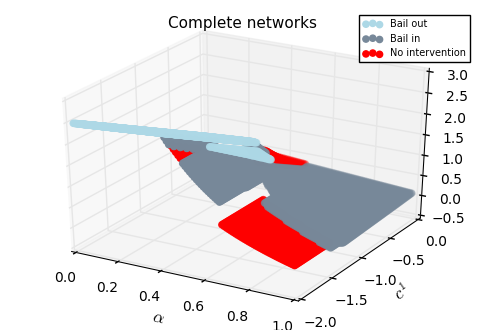

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size = 12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size = 12)
ax.scatter(bo_complete_alpha,bo_complete_c,bo_complete,color="lightblue",label="Bail out")
ax.scatter(bi_complete_alpha,bi_complete_c,bi_complete,color="lightslategrey",label="Bail in")
ax.scatter(df_complete_alpha,df_complete_c,df_complete,color="red",label="No intervention")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("Complete networks",size=11)

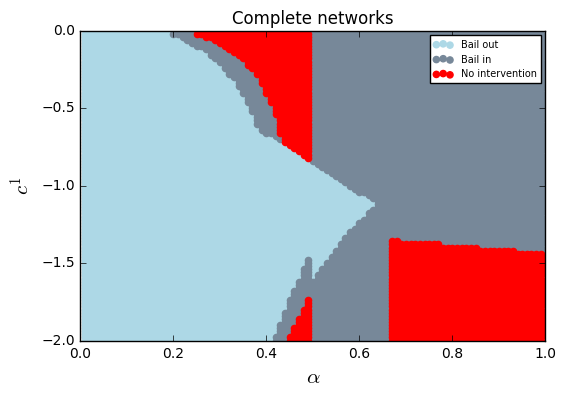

In [9]:
plt.scatter(bo_complete_alpha,bo_complete_c,color="lightblue",label="Bail out")
plt.scatter(bi_complete_alpha,bi_complete_c,color="lightslategrey",label="Bail in")
plt.scatter(df_complete_alpha,df_complete_c,color="red",label="No intervention")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("Complete networks",size=12)

In [10]:
# R1 
bo_r1 =[]
bo_r1_alpha =[]
bo_r1_c=[]
bi_r1 =[]
bi_r1_alpha =[]
bi_r1_c=[]
df_r1= []
df_r1_alpha =[]
df_r1_c=[]
r1_def_num =[]
r1_def_alpha=[]
r1_def_c=[]

alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        p,wn,w_s,name = r1(i,-j,0.15)
        r1_def_alpha.append(i)
        r1_def_c.append(j)
        count =0
        for k in range(len(p)):
            if L[k] != p[k]:
                count+=1
        r1_def_num.append(count)
        
        if not math.isnan(w_s):
            if name == 'Public bailin':
                bo_r1_alpha.append(i)
                bo_r1_c.append(-j)
                bo_r1.append(w_s)
            elif name == 'Bailin':
                bi_r1_alpha.append(i)
                bi_r1_c.append(-j)
                bi_r1.append(w_s)
            elif name == "Default":
                df_r1_alpha.append(i)
                df_r1_c.append(-j)
                df_r1.append(w_s)

0.8 -0.3 wp: 0.555 wn: 0.2
w_r: -0.005
____
0.8 -0.28 wp: 0.53 wn: 0.195
w_r: -0.015
____
0.8 -0.26 wp: 0.505 wn: 0.19
w_r: -0.025
____
0.8 -0.24 wp: 0.48 wn: 0.185
w_r: -0.035
____
0.8 -0.22 wp: 0.455 wn: 0.18
w_r: -0.045
____
0.8 -0.2 wp: 0.43 wn: 0.18
w_r: -0.05
____
0.8 -0.18 wp: 0.405 wn: 0.18
w_r: -0.055
____
0.8 -0.16 wp: 0.38 wn: 0.18
w_r: -0.06
____
0.8 -0.14 wp: 0.355 wn: 0.18
w_r: -0.065
____
0.8 -0.12 wp: 0.33 wn: 0.18
w_r: -0.07
____
0.8 -0.1 wp: 0.305 wn: 0.18
w_r: -0.075
____
0.8 -0.08 wp: 0.28 wn: 0.18
w_r: -0.08
____
0.8 -0.06 wp: 0.255 wn: 0.18
w_r: -0.085
____
0.8 -0.04 wp: 0.23 wn: 0.18
w_r: -0.09
____
0.8 -0.02 wp: 0.205 wn: 0.18
w_r: -0.095
____
0.81 -0.3 wp: 0.54637037037 wn: 0.193827160494
w_r: -0.0118024691358
____
0.81 -0.28 wp: 0.521679012346 wn: 0.189135802469
w_r: -0.0211851851852
____
0.81 -0.26 wp: 0.496987654321 wn: 0.184444444444
w_r: -0.0305679012346
____
0.81 -0.24 wp: 0.472296296296 wn: 0.17975308642
w_r: -0.039950617284
____
0.81 -0.22 wp: 0.4476049

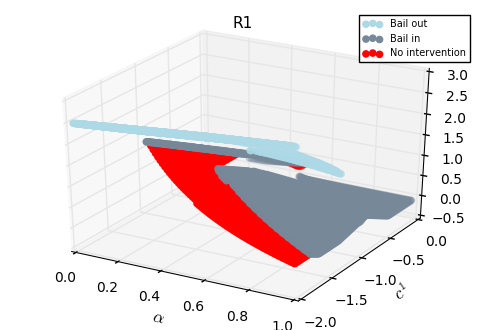

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size = 12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size=12)
ax.scatter(bo_r1_alpha,bo_r1_c,bo_r1,color="lightblue",label="Bail out")
ax.scatter(bi_r1_alpha,bi_r1_c,bi_r1,color="lightslategrey",label='Bail in')
ax.scatter(df_r1_alpha,df_r1_c,df_r1,color="red",label="No intervention")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("R1",size=11)

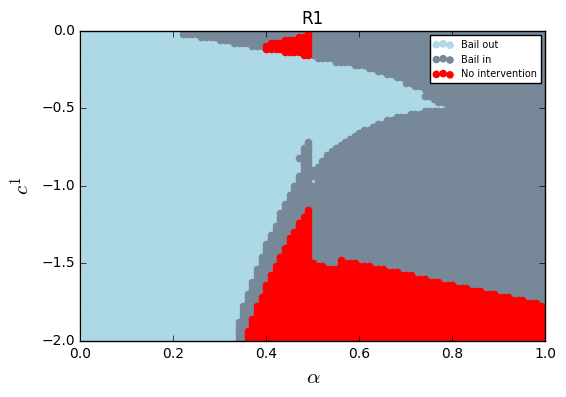

In [12]:
plt.scatter(bo_r1_alpha,bo_r1_c,color="lightblue",label="Bail out")
plt.scatter(bi_r1_alpha,bi_r1_c,color='lightslategrey',label='Bail in')
plt.scatter(df_r1_alpha,df_r1_c,color="red",label="No intervention")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("R1",size=12)

In [13]:
# R2
bo_r2 =[]
bo_r2_alpha =[]
bo_r2_c=[]
bi_r2 =[]
bi_r2_alpha =[]
bi_r2_c=[]
df_r2= []
df_r2_alpha =[]
df_r2_c=[]
r2_def_alpha=[]
r2_def_c=[]
r2_def_num=[]

alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        p,t,w_s,name = r2(i,-j,0.15)
        r2_def_alpha.append(i)
        r2_def_c.append(j)
        count =0
        for k in range(len(p)):
            if L[k] != p[k]:
                count+=1
        r2_def_num.append(count)
        
        if not math.isnan(w_s):
            if name == 'Public bailin':
                bo_r2_alpha.append(i)
                bo_r2_c.append(-j)
                bo_r2.append(w_s)
            elif name == 'Bailin':
                bi_r2_alpha.append(i)
                bi_r2_c.append(-j)
                bi_r2.append(w_s)
            elif name == "Default":
                df_r2_alpha.append(i)
                df_r2_c.append(-j)
                df_r2.append(w_s)

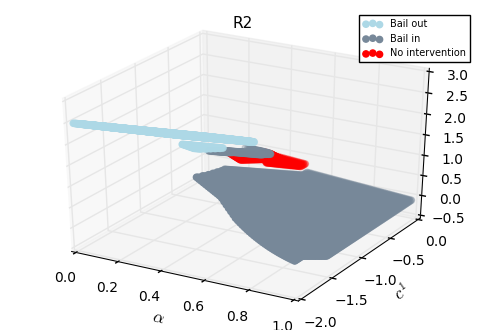

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size=12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size=12)
ax.scatter(bo_r2_alpha,bo_r2_c,bo_r2,color="lightblue",label="Bail out" )
ax.scatter(bi_r2_alpha,bi_r2_c,bi_r2,color="lightslategrey",label="Bail in")
ax.scatter(df_r2_alpha,df_r2_c,df_r2,color="red",label="No intervention")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("R2",size=11)

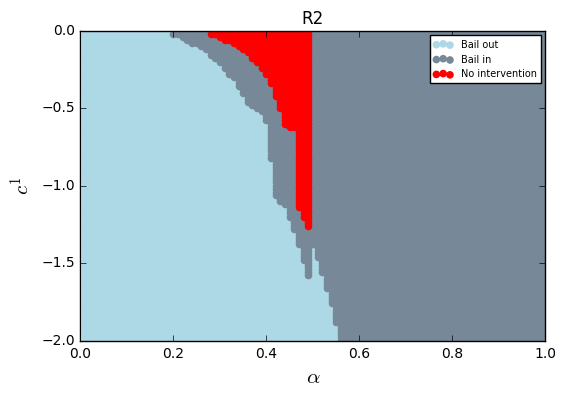

In [15]:
plt.scatter(bo_r2_alpha,bo_r2_c,color="lightblue",label="Bail out")
plt.scatter(bi_r2_alpha,bi_r2_c,color="lightslategrey",label="Bail in")
plt.scatter(df_r2_alpha,df_r2_c,color="red",label="No intervention")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("R2",size=12)

In [16]:
# Full comparision
complete_ = []
r1_ = []
r2_ = []
core_ =[]
complete_alpha = []
complete_c =[]
r1_alpha=[]
r1_c=[]
r2_alpha =[]
r2_c =[]
core_alpha =[]
core_c =[]
alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        w_s_c = complete(i,-j,0.15)[2]
        w_s_1 = r1(i,-j,0.15)[2]
        w_s_2 = r2(i,-j,0.15)[2]
        #w_s_core=core_p(i,-j,0.15)[2]
        w_max = min(w_s_c,w_s_1,w_s_2)
        if w_max == w_s_c:
            complete_.append(w_max)
            complete_alpha.append(i)
            complete_c.append(-j)
        elif w_max == w_s_1:
            r1_.append(w_max)
            r1_alpha.append(i)
            r1_c.append(-j)
        elif w_max == w_s_2:
            r2_.append(w_max)
            r2_alpha.append(i)
            r2_c.append(-j)
        #elif w_max == w_s_core:
            #core_.append(w_max)
            #core_alpha.append(i)
            #core_c.append(-j)

0.8 -0.3 wp: 0.555 wn: 0.2
w_r: -0.005
____
0.8 -0.28 wp: 0.53 wn: 0.195
w_r: -0.015
____
0.8 -0.26 wp: 0.505 wn: 0.19
w_r: -0.025
____
0.8 -0.24 wp: 0.48 wn: 0.185
w_r: -0.035
____
0.8 -0.22 wp: 0.455 wn: 0.18
w_r: -0.045
____
0.8 -0.2 wp: 0.43 wn: 0.18
w_r: -0.05
____
0.8 -0.18 wp: 0.405 wn: 0.18
w_r: -0.055
____
0.8 -0.16 wp: 0.38 wn: 0.18
w_r: -0.06
____
0.8 -0.14 wp: 0.355 wn: 0.18
w_r: -0.065
____
0.8 -0.12 wp: 0.33 wn: 0.18
w_r: -0.07
____
0.8 -0.1 wp: 0.305 wn: 0.18
w_r: -0.075
____
0.8 -0.08 wp: 0.28 wn: 0.18
w_r: -0.08
____
0.8 -0.06 wp: 0.255 wn: 0.18
w_r: -0.085
____
0.8 -0.04 wp: 0.23 wn: 0.18
w_r: -0.09
____
0.8 -0.02 wp: 0.205 wn: 0.18
w_r: -0.095
____
0.81 -0.3 wp: 0.54637037037 wn: 0.193827160494
w_r: -0.0118024691358
____
0.81 -0.28 wp: 0.521679012346 wn: 0.189135802469
w_r: -0.0211851851852
____
0.81 -0.26 wp: 0.496987654321 wn: 0.184444444444
w_r: -0.0305679012346
____
0.81 -0.24 wp: 0.472296296296 wn: 0.17975308642
w_r: -0.039950617284
____
0.81 -0.22 wp: 0.4476049

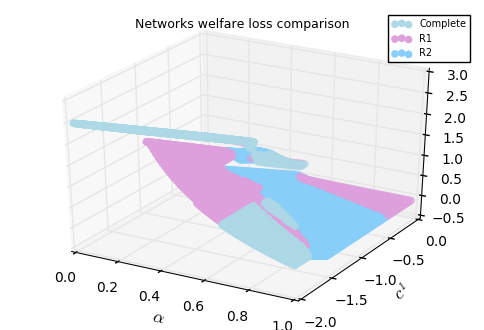

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size=12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size=12)
ax.scatter(complete_alpha,complete_c,complete_,color="lightblue",label="Complete")
ax.scatter(r1_alpha,r1_c,r1_,color="plum",label = "R1")
ax.scatter(r2_alpha,r2_c,r2_,color="lightskyblue",label="R2")
#ax.scatter(core_alpha,core_c,core_,color="navajowhite",label="Core periphery")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("Networks welfare loss comparison",size=9)

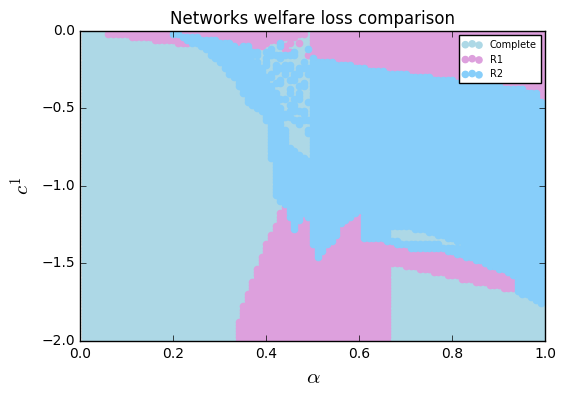

In [18]:
plt.scatter(complete_alpha,complete_c,color="lightblue",label="Complete")
plt.scatter(r1_alpha,r1_c,color="plum",label = "R1")
plt.scatter(r2_alpha,r2_c,color="lightskyblue",label="R2")
#plt.scatter(core_alpha,core_c,color="navajowhite",label="Core periphery")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("Networks welfare loss comparison",size=12)

# Price contagious

## Complete

In [19]:
def complete_pc(alpha,c,cap,K):
    bank_inf = np.empty([11,3])
    bank_inf[0,:]=[1.5,c,0.4]
    for i in range(1,6):
        bank_inf[i,:]=[1,0,cap]
    for i in range(6,11):
        bank_inf[i,:]=[1,0,1.2]
    beta =0.9
    p = [1.5,1,1,1,1,1,1,1,1,1,1]
    threshold = 0.001
    Finish = False
    while not Finish:
        p_temp = []
        for i in range(11):
            get_return = sum(p)*0.1-0.1*p[i]
            val_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return
            if val_paid >= bank_inf[i,0]:
                p_temp.append(bank_inf[i,0])
            else:
                new_paid = max(bank_inf[i,1]+alpha*bank_inf[i,2]+get_return*beta,0)
                p_temp.append(new_paid)
        diff = np.max(abs(np.array(p)-np.array(p_temp)))
        if diff <= threshold:
            Finish = True
            #print(np.around(p_temp,decimals=2))
        else:
            p = p_temp.copy()
    p = p_temp.copy()
    l = []
    for i in range(11):
        get_return = sum(p)*0.1-0.1*p[i]
        l_ = min((bank_inf[i,0]-bank_inf[i,1]-get_return)/alpha,bank_inf[i,2])
        l.append(l_)
    V0 = []
    for i in range(11):
        get_return = sum(bank_inf[:,0])*0.1-0.1*bank_inf[i,0]
        V0_i = bank_inf[i,1]+bank_inf[i,2]+get_return-bank_inf[i,0]
        V0.append(V0_i)
    zeta = []
    for i in range(11):
        zeta_i = 0.1*(sum(bank_inf[:,0])-bank_inf[i,0]) - 0.1*(sum(p)-p[i])
        zeta.append(zeta_i)
    xi = []
    for i in range(11):
        xi_i = min(zeta[i],V0[i]-(1-alpha)*bank_inf[i,2])
        xi.append(xi_i)
    l_hat = []
    for i in range(11):
        l_hat_i = max((xi[i]+bank_inf[i,2]-V0[i])/alpha,0)
        l_hat_i = min(l_hat_i,bank_inf[i,2])
        l_hat.append(l_hat_i)
        
    ## Calculate extra loss
    e = bank_inf[:,2]
    ex_ls = extra_loss(e,5,l_hat)
    ## 
    
    VN=[]
    for i in range(11):
        if i== 0:
            VN.append(0)
        else:
            VN_i = V0[i]-xi[i]-(1-alpha)*l_hat[i] - ex_ls[i]
            VN.append(VN_i)
    s = bank_inf[0,1]+alpha*l[0]+beta*(sum(p)*0.1-0.1*p[i])
    wn = sum(V0)-sum(VN)-min(s,0)
    l_star = []
    for i in range(11):
        A_i = 0.1*(sum(bank_inf[:,0])-bank_inf[i,0])
        li_star = min(max((bank_inf[i,0]-bank_inf[i,1]-A_i)/alpha,0),bank_inf[i,2])
        l_star.append(li_star)
    ## Calculate l_star loss
    ex_ls_star = extra_loss(e,5,l_star)
    ##
    
    eta = []
    for i in range(11):
        eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
        eta.append(eta_i)
    nu = []
    if alpha >= 0.5:
        for i in range(11):
            nu_i = xi[i]-(1-alpha)*(l_hat[i]-l_star[i])+(ex_ls_star[i]-ex_ls[i])
            nu.append(nu_i)
    else:
        nu = eta.copy()
    b = []
    lambda_sub = []
    for i in range(1,11):
        if alpha >= 0.5:
            b.append(xi[i])
            lambda_sub.append(0)
        else:
            eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
            b.append(eta_i)
            lambda_sub.append(alpha*l_star[i])
    if alpha <0.5:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)
    else:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)-alpha*abs(bank_inf[0,2])
    if alpha >= 0.5:
        wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))+sum(ex_ls)
    else:
        wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))
    if alpha < 0.5:
        b0 = B + alpha*bank_inf[0,2]- sum(abs(np.array(b)))
    else:
        b0 = B - sum(abs(np.array(b)))

    if wn>wp:
        return (p,wn,wp,'Public bailin')
    else:
        nu_SC = nu[1:]
        sequence = [i[0] for i in sorted(enumerate(nu_SC), key=lambda x:x[1],reverse=True)]
        w_star = 0
        for i in range(len(sequence)):
            accept = sequence[:i+1]
            ## calculate loss
            l_hat_1 = l_star.copy()
            for i in accept:
                l_hat_1[i]=min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2])
            ex_ls_1 = extra_loss(e,5,l_hat_1)
            ##
            b_acc = 0
            lambda_acc = 0
            l_hat_acc = 0
            l_star_acc =0
            for i in accept:
                b_acc += abs(b[i])
                lambda_acc += abs(lambda_sub[i])
                l_hat_acc_i = min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2]) # check the i+1
                l_hat_acc+= l_hat_acc_i
                l_star_acc+=l_star[i+1]
            w_m = b0+sum(abs(np.array(b)))-b_acc+lambda_acc+(1-alpha)*((sum(abs(np.array(l_star))))-l_star_acc+l_hat_acc)+sum(ex_ls_1)
            if w_m < wn:
                if len(accept)<len(sequence):
                    w_star = min(w_m,wn-nu_SC[sequence[len(accept)]])
                    return (p,wn,w_star,'Bailin')
        if w_star == 0:
            return (p,wn,wn,'Default')
    

## R1

In [23]:
def r1_pc(alpha,c,cap,K):
    bank_inf = np.empty([11,3])
    bank_inf[0,:]=[1.5,c,0.4]
    for i in range(1,6):
        bank_inf[i,:]=[1,0,cap]
    for i in range(6,11):
        bank_inf[i,:]=[1,0,1.2]
    beta =0.9
    p = [1.5,1,1,1,1,1,1,1,1,1,1]
    threshold = 0.0001
    Finish = False
    while not Finish:
        p_temp = []
        for i in range(11):
            if i==0:
                get_return = p[-1]
            else:
                get_return = p[i-1]
            val_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return
            if val_paid >= bank_inf[i,0]:
                p_temp.append(bank_inf[i,0])
            else:
                new_paid = max(bank_inf[i,1]+alpha*bank_inf[i,2]+get_return*beta,0)
                p_temp.append(new_paid)
        diff = np.max(abs(np.array(p)-np.array(p_temp)))
        if diff <= threshold:
            Finish = True    
        else:
            p = p_temp.copy()
    p = p_temp.copy()
    l = []
    for i in range(11):
        if i==0:
            get_return = p[-1]
        else:
            get_return = p[i-1]
        l_ = min((bank_inf[i,0]-bank_inf[i,1]-get_return)/alpha,bank_inf[i,2])
        l.append(l_)
    V0 = []
    for i in range(11):
        if i==0:
            get_return = bank_inf[-1,0]
        else:
            get_return=bank_inf[i-1,0]
        V0_i = bank_inf[i,1]+bank_inf[i,2]+get_return-bank_inf[i,0]
        V0.append(V0_i)
    zeta = []
    for i in range(11):
        if i == 0:
            zeta_i = bank_inf[-1,0]-p[-1]
            zeta.append(zeta_i)
        else:
            zeta_i = bank_inf[i-1,0]-p[i-1]
            zeta.append(zeta_i)
    xi = []
    for i in range(11):
        xi_i = min(zeta[i],V0[i]-(1-alpha)*bank_inf[i,2])
        xi.append(xi_i)
    l_hat = []
    for i in range(11):
        l_hat_i = max((xi[i]+bank_inf[i,2]-V0[i])/alpha,0)
        l_hat_i = min(l_hat_i,bank_inf[i,2])
        l_hat.append(l_hat_i)
    ## Calculate extra loss
    e = bank_inf[:,2]
    ex_ls = extra_loss(e,5,l_hat)
    ## 
    
    VN=[]
    for i in range(11):
        if i== 0:
            VN.append(0)
        else:
            VN_i = V0[i]-xi[i]-(1-alpha)*l_hat[i]- ex_ls[i]
            VN.append(VN_i)
    s = bank_inf[0,1]+alpha*l[0]+beta*p[-1]
    wn = sum(V0)-sum(VN)-min(s,0)
    l_star = []
    for i in range(11):
        if i ==0:
            A_i = bank_inf[0,0]
        else:
            A_i = bank_inf[i-1,0]
        li_star = min(max((bank_inf[i,0]-bank_inf[i,1]-A_i)/alpha,0),bank_inf[i,2])
        l_star.append(li_star)
    ## Calculate l_star loss
    ex_ls_star = extra_loss(e,5,l_star)
    ##
    
    eta = []
    for i in range(11):
        eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
        eta.append(eta_i)
    nu = []
    if alpha >= 0.5:
        for i in range(11):
            nu_i = xi[i]-(1-alpha)*(l_hat[i]-l_star[i])+(ex_ls_star[i]-ex_ls[i])
            nu.append(nu_i)
    else:
        nu = eta.copy()
    b = []
    lambda_sub = []
    for i in range(1,11):
        if alpha >= 0.5:
            b.append(xi[i])
            lambda_sub.append(0)
        else:
            eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
            b.append(eta_i)
        lambda_sub.append(alpha*l_star[i])
    if alpha <0.5:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)
    else:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)-alpha*abs(bank_inf[0,2])
    if alpha >= 0.5:
        wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))+sum(ex_ls)
    else:
        wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))
    if alpha < 0.5:
        b0 = B + alpha*bank_inf[0,2]- sum(abs(np.array(b)))
    else:
        b0 = B - sum(abs(np.array(b)))
    
    
    if wn>wp:
        return (p,wn,wp,'Public bailin')
    else:
        nu_SC = nu[1:]
        sequence = [i[0] for i in sorted(enumerate(nu_SC), key=lambda x:x[1],reverse=True)]
        w_star = 0
        for i in range(len(sequence)):
            accept = sequence[:i+1]
            ## calculate loss
            l_hat_1 = l_star.copy()
            for i in accept:
                l_hat_1[i]=min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2])
            ex_ls_1 = extra_loss(e,5,l_hat_1)
            ##
            b_acc = 0
            lambda_acc = 0
            l_hat_acc = 0
            l_star_acc =0
            for i in accept:
                b_acc += abs(b[i])
                lambda_acc += abs(lambda_sub[i])
                l_hat_acc_i = min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2]) # check the i+1
                l_hat_acc+= l_hat_acc_i
                l_star_acc+=l_star[i+1]
            w_m = b0+sum(abs(np.array(b)))-b_acc+lambda_acc+(1-alpha)*((sum(abs(np.array(l_star))))-l_star_acc+l_hat_acc)+sum(ex_ls_1)
            if w_m < wn:
                if len(accept)<len(sequence):
                    w_star = min(w_m,wn-nu_SC[sequence[len(accept)]])
                
                    return (p,wn,w_star,'Bailin')
        if w_star == 0:
            return (p,wn,wn,'Default')

## R2

In [21]:
def r2_pc(alpha,c,cap,K):
    bank_inf = np.empty([11,3])
    bank_inf[0,:]=[1.5,c,0.4]
    for i in range(1,6):
        bank_inf[i,:]=[1,0,cap]
    for i in range(6,11):
        bank_inf[i,:]=[1,0,1.2]
    beta =0.9
    p = [1.5,1,1,1,1,1,1,1,1,1,1]
    threshold = 0.0001
    Finish = False
    while not Finish:
        p_temp = []
        for i in range(11):
            if i==10:
                get_return = p[0]
            else:
                get_return = p[i+1]
            val_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return
            if val_paid >= bank_inf[i,0]:
                p_temp.append(bank_inf[i,0])
            else:
                new_paid = bank_inf[i,1]+alpha*bank_inf[i,2]+get_return*beta
                p_temp.append(new_paid)
        diff = np.max(abs(np.array(p)-np.array(p_temp)))
        if diff <= threshold:
            Finish = True
        else:
            p = p_temp.copy()
    p =p_temp.copy()
    l = []
    for i in range(11):
        if i==10:
            get_return = p[0]
        else:
            get_return = p[i+1]
        l_ = min((bank_inf[i,0]-bank_inf[i,1]-get_return)/alpha,bank_inf[i,2])
        l.append(l_)
    V0 = []
    for i in range(11):
        if i==10:
            get_return = bank_inf[0,0]
        else:
            get_return=bank_inf[i+1,0]
        V0_i = bank_inf[i,1]+bank_inf[i,2]+get_return-bank_inf[i,0]
        V0.append(V0_i)
    zeta = []
    for i in range(11):
        if i == 10:
            zeta_i = bank_inf[0,0]-p[0]
            zeta.append(zeta_i)
        else:
            zeta_i = bank_inf[i+1,0]-p[i+1]
            zeta.append(zeta_i)
    xi = []
    for i in range(11):
        xi_i = min(zeta[i],V0[i]-(1-alpha)*bank_inf[i,2])
        xi.append(xi_i)
    l_hat = []
    for i in range(11):
        l_hat_i = max((xi[i]+bank_inf[i,2]-V0[i])/alpha,0)
        l_hat_i = min(l_hat_i,bank_inf[i,2])
        l_hat.append(l_hat_i)
    ## Calculate extra loss
    e = bank_inf[:,2]
    ex_ls = extra_loss(e,5,l_hat)
    ## 
    
    VN=[]
    for i in range(11):
        if i== 0:
            VN.append(0)
        else:
            VN_i = V0[i]-xi[i]-(1-alpha)*l_hat[i]-ex_ls[i]
            VN.append(VN_i)
    s = bank_inf[0,1]+alpha*l[0]+beta*p[1]
    wn = sum(V0)-sum(VN)-min(s,0)
    l_star = []
    for i in range(11):
        if i ==10:
            A_i = bank_inf[0,0]
        else:
            A_i = bank_inf[i+1,0]
        li_star = min(max((bank_inf[i,0]-bank_inf[i,1]-A_i)/alpha,0),bank_inf[i,2])
        l_star.append(li_star)
    ## Calculate l_star loss
    ex_ls_star = extra_loss(e,5,l_star)
    ##
    
    eta = []
    for i in range(11):
        eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
        eta.append(eta_i)
    nu = []
    if alpha >= 0.5:
        for i in range(11):
            nu_i = xi[i]-(1-alpha)*(l_hat[i]-l_star[i])+(ex_ls_star[i]-ex_ls[i])
            nu.append(nu_i)
    else:
        nu = eta.copy()
    b = []
    lambda_sub = []
    for i in range(1,11):
        if alpha >= 0.5:
            b.append(xi[i])
            lambda_sub.append(0)
        else:
            eta_i = min(zeta[i],max(V0[i]-bank_inf[i,2],0))
            b.append(eta_i)
        lambda_sub.append(alpha*l_star[i])
    if alpha <0.5:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)
    else:
        B = abs(bank_inf[0,0]-bank_inf[0,1]-1)-alpha*abs(bank_inf[0,2])
    if alpha >= 0.5:
        wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))+sum(ex_ls)
    else:
        wp = B+min(alpha,1-alpha)*sum(abs(np.array(l_star)))
    if alpha < 0.5:
        b0 = B + alpha*bank_inf[0,2]- sum(abs(np.array(b)))
    else:
        b0 = B - sum(abs(np.array(b)))
    if wn>wp:
        return (p,wn,wp,'Public bailin')
    else:
        nu_SC = nu[1:]
        sequence = [i[0] for i in sorted(enumerate(nu_SC), key=lambda x:x[1],reverse=True)]
        w_star = 0
        for i in range(len(sequence)):
            accept = sequence[:i+1]
            ## calculate loss
            l_hat_1 = l_star.copy()
            for i in accept:
                l_hat_1[i]=min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2])
            ex_ls_1 = extra_loss(e,5,l_hat_1)
            ##
            b_acc = 0
            lambda_acc = 0
            l_hat_acc = 0
            l_star_acc =0
            for i in accept:
                b_acc += abs(b[i])
                lambda_acc += abs(lambda_sub[i])
                l_hat_acc_i = min(max((b[i]-lambda_sub[i]+bank_inf[i+1,2]-V0[i+1])/alpha,0),bank_inf[i+1,2]) # check the i+1
                l_hat_acc+= l_hat_acc_i
                l_star_acc+=l_star[i+1]
            w_m = b0+sum(abs(np.array(b)))-b_acc+lambda_acc+(1-alpha)*((sum(abs(np.array(l_star))))-l_star_acc+l_hat_acc)+sum(ex_ls_1)
            if w_m < wn:
                if len(accept)<len(sequence):
                    w_star = min(w_m,wn-nu_SC[sequence[len(accept)]])
                    return (p,wn,w_star,'Bailin')
        if w_star == 0:
            return (p,wn,wn,'Default')

## Plot

In [22]:
# Complete Price contagion
bo_complete_pc =[]
bo_complete_pc_alpha =[]
bo_complete_pc_c=[]
bi_complete_pc =[]
bi_complete_pc_alpha =[]
bi_complete_pc_c=[]
df_complete_pc = []
df_complete_pc_alpha =[]
df_complete_pc_c=[]

alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        w_s,name = complete_pc(i,-j,0.15,5)[2:]
        if not math.isnan(w_s):
            if name == 'Public bailin':
                bo_complete_pc_alpha.append(i)
                bo_complete_pc_c.append(-j)
                bo_complete_pc.append(w_s)
            elif name == 'Bailin':
                bi_complete_pc_alpha.append(i)
                bi_complete_pc_c.append(-j)
                bi_complete_pc.append(w_s)
            elif name == "Default":
                df_complete_pc_alpha.append(i)
                df_complete_pc_c.append(-j)
                df_complete_pc.append(w_s)


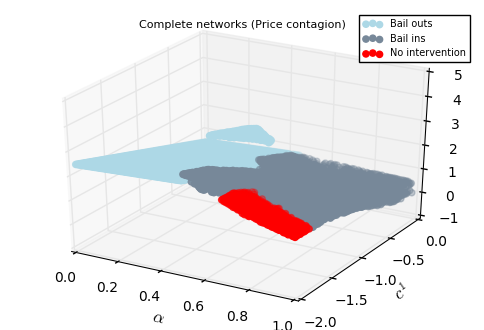

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size=12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size=12)
ax.scatter(bo_complete_pc_alpha,bo_complete_pc_c,bo_complete_pc,color="lightblue",label="Bail outs")
ax.scatter(bi_complete_pc_alpha,bi_complete_pc_c,bi_complete_pc,color="lightslategrey",label="Bail ins")
ax.scatter(df_complete_pc_alpha,df_complete_pc_c,df_complete_pc,color="red",label="No intervention")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("Complete networks (Price contagion)",size=8)

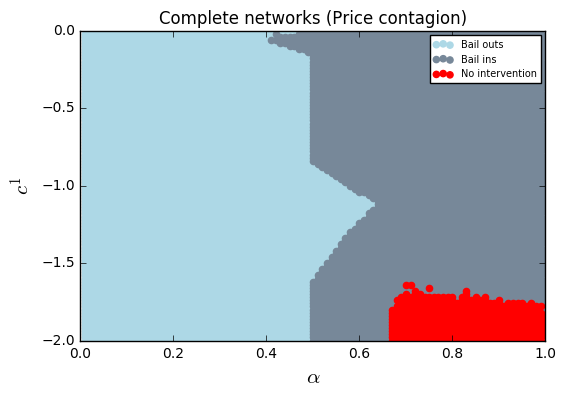

In [25]:
plt.scatter(bo_complete_pc_alpha,bo_complete_pc_c,color="lightblue",label="Bail outs")
plt.scatter(bi_complete_pc_alpha,bi_complete_pc_c,color="lightslategrey",label="Bail ins")
plt.scatter(df_complete_pc_alpha,df_complete_pc_c,color="red",label="No intervention")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("Complete networks (Price contagion)",size=12)

In [26]:
# R1 Price contagion
bo_r1_pc =[]
bo_r1_pc_alpha =[]
bo_r1_pc_c=[]
bi_r1_pc =[]
bi_r1_pc_alpha =[]
bi_r1_pc_c=[]
df_r1_pc= []
df_r1_pc_alpha =[]
df_r1_pc_c=[]

alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        w_s,name = r1_pc(i,-j,0.15,5)[2:]
        if not math.isnan(w_s):
            if name == 'Public bailin':
                bo_r1_pc_alpha.append(i)
                bo_r1_pc_c.append(-j)
                bo_r1_pc.append(w_s)
            elif name == 'Bailin':
                bi_r1_pc_alpha.append(i)
                bi_r1_pc_c.append(-j)
                bi_r1_pc.append(w_s)
            elif name == "Default":
                df_r1_pc_alpha.append(i)
                df_r1_pc_c.append(-j)
                df_r1_pc.append(w_s)

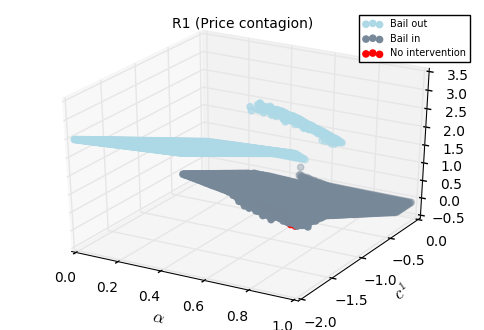

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size=12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size=12)
ax.scatter(bo_r1_pc_alpha,bo_r1_pc_c,bo_r1_pc,color="lightblue",label="Bail out")
ax.scatter(bi_r1_pc_alpha,bi_r1_pc_c,bi_r1_pc,color="lightslategrey",label='Bail in')
ax.scatter(df_r1_pc_alpha,df_r1_pc_c,df_r1_pc,color="red",label="No intervention")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("R1 (Price contagion)",size=10)

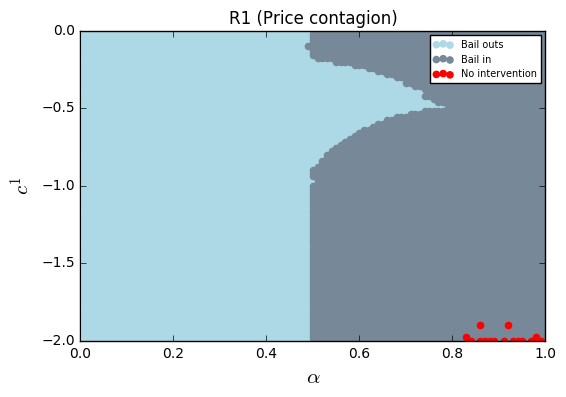

In [28]:
plt.scatter(bo_r1_pc_alpha,bo_r1_pc_c,color="lightblue",label="Bail outs")
plt.scatter(bi_r1_pc_alpha,bi_r1_pc_c,color='lightslategrey',label='Bail in')
plt.scatter(df_r1_pc_alpha,df_r1_pc_c,color="red",label="No intervention")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("R1 (Price contagion)",size=12)

In [29]:
# R2
bo_r2_pc =[]
bo_r2_pc_alpha =[]
bo_r2_pc_c=[]
bi_r2_pc =[]
bi_r2_pc_alpha =[]
bi_r2_pc_c=[]
df_r2_pc= []
df_r2_pc_alpha =[]
df_r2_pc_c=[]

alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        w_s,name = r2_pc(i,-j,0.15,0.5)[2:]
        if not math.isnan(w_s):
            if name == 'Public bailin':
                bo_r2_pc_alpha.append(i)
                bo_r2_pc_c.append(-j)
                bo_r2_pc.append(w_s)
            elif name == 'Bailin':
                bi_r2_pc_alpha.append(i)
                bi_r2_pc_c.append(-j)
                bi_r2_pc.append(w_s)
            elif name == "Default":
                df_r2_pc_alpha.append(i)
                df_r2_pc_c.append(-j)
                df_r2_pc.append(w_s)

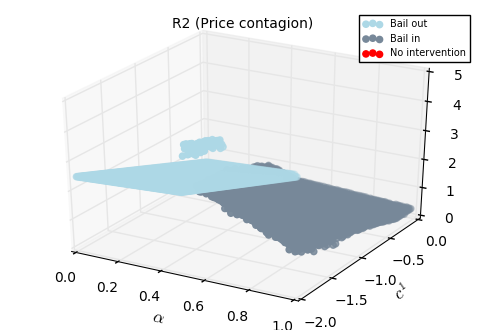

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2,size=12)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2,size=12)
ax.scatter(bo_r2_pc_alpha,bo_r2_pc_c,bo_r2_pc,color="lightblue",label="Bail out" )
ax.scatter(bi_r2_pc_alpha,bi_r2_pc_c,bi_r2_pc,color="lightslategrey",label="Bail in")
ax.scatter(df_r2_pc_alpha,df_r2_pc_c,df_r2_pc,color="red",label="No intervention")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("R2 (Price contagion)",size=10)

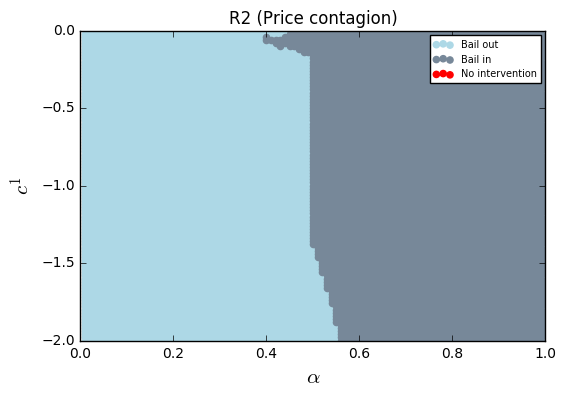

In [31]:
plt.scatter(bo_r2_pc_alpha,bo_r2_pc_c,color="lightblue",label="Bail out" )
plt.scatter(bi_r2_pc_alpha,bi_r2_pc_c,color="lightslategrey",label="Bail in")
plt.scatter(df_r2_pc_alpha,df_r2_pc_c,color="red",label="No intervention")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("R2 (Price contagion)",size=12)

In [32]:
# Full comparision
complete_pc_ = []
r1_pc_ = []
r2_pc_ = []
core_pc_=[]
complete_pc_alpha = []
complete_pc_c =[]
r1_pc_alpha=[]
r1_pc_c=[]
r2_pc_alpha =[]
r2_pc_c =[]
core_pc_alpha =[]
core_pc_c =[]
alpha_r = [i/100 for i in range(1,100)]
c_r = [i/100 for i in range(200,0,-2)]
for i in alpha_r:
    for j in c_r:
        w_s_c = complete_pc(i,-j,0.15,5)[2]
        w_s_1 = r1_pc(i,-j,0.15,5)[2]
        w_s_2 = r2_pc(i,-j,0.15,5)[2]
        #w_s_core = core_p_pc(i,-j,0.15,5)[2]
        w_max = min(w_s_c,w_s_1,w_s_2)
        if w_max == w_s_c:
            complete_pc_.append(w_max)
            complete_pc_alpha.append(i)
            complete_pc_c.append(-j)
        elif w_max == w_s_1:
            r1_pc_.append(w_max)
            r1_pc_alpha.append(i)
            r1_pc_c.append(-j)
        elif w_max == w_s_2:
            r2_pc_.append(w_max)
            r2_pc_alpha.append(i)
            r2_pc_c.append(-j)
        #elif w_max == w_s_core:
            #core_pc_.append(w_max)
            #core_pc_alpha.append(i)
            #core_pc_c.append(-j)

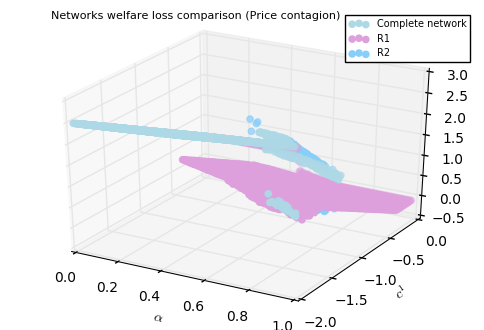

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xLabel = ax.set_xlabel(r'$\alpha$', linespacing=3.2)
yLabel = ax.set_ylabel(r'$c^1$', linespacing=3.2)
ax.scatter(complete_pc_alpha,complete_pc_c,complete_pc_,color="lightblue",label="Complete network")
ax.scatter(r1_pc_alpha,r1_pc_c,r1_pc_,color="plum",label = "R1")
ax.scatter(r2_pc_alpha,r2_pc_c,r2_pc_,color="lightskyblue",label="R2")
#ax.scatter(core_pc_alpha,core_pc_c,core_pc_,color="navajowhite",label="Core periphery")
ax.legend(prop={'size':7})
ax.set_xlim((0,1))
ax.set_ylim((-2,0))
ax.set_title("Networks welfare loss comparison (Price contagion)",position=(0.4, 1.03),size=8)


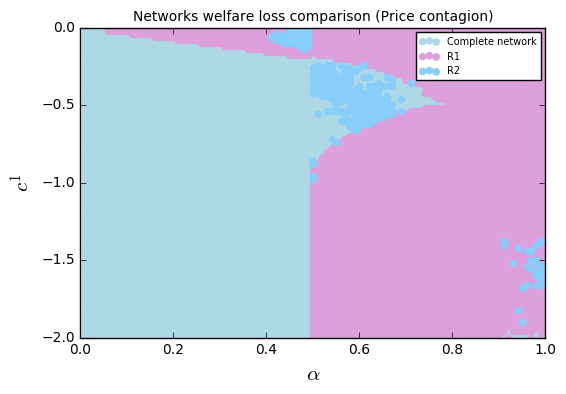

In [34]:
plt.scatter(complete_pc_alpha,complete_pc_c,color="lightblue",label="Complete network")
plt.scatter(r1_pc_alpha,r1_pc_c,color="plum",label = "R1")
plt.scatter(r2_pc_alpha,r2_pc_c,color="lightskyblue",label="R2")
#plt.scatter(core_pc_alpha,core_pc_c,color="navajowhite",label="Core periphery")
plt.ylim((-2,0))
plt.xlim((0,1))
plt.xlabel(r'$\alpha$', linespacing=3.2,size=15)
plt.ylabel(r'$c^1$', linespacing=3.2,size=15)
plt.legend(prop={'size':7})
plt.title("Networks welfare loss comparison (Price contagion)",size=10)